<a href="https://colab.research.google.com/github/baileysmoko/Fabric/blob/main/LTC_Momentum_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

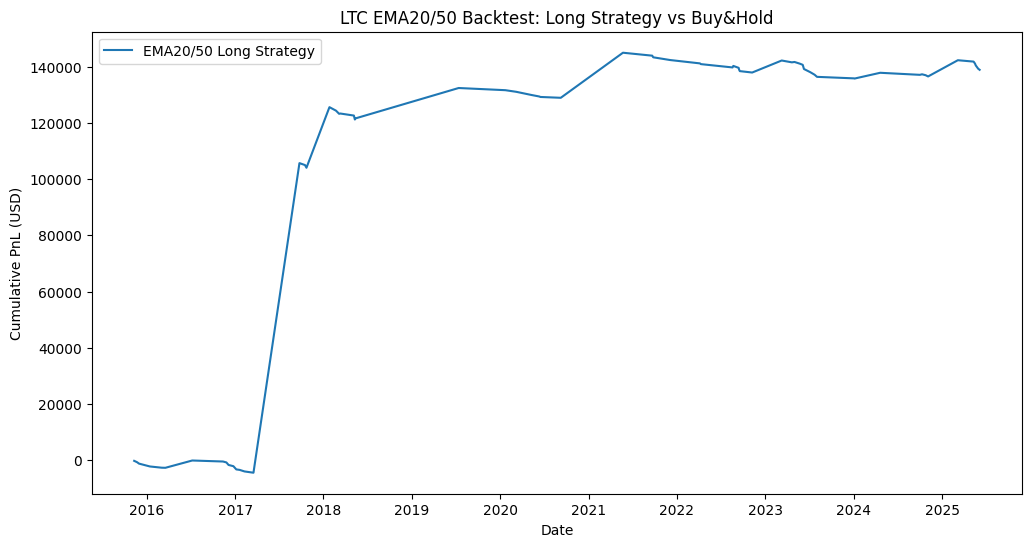


All Trades:
                  entry_date                 exit_date  year  side  \
0  2015-10-07 00:00:00+00:00 2015-11-11 00:00:00+00:00  2015  long   
1  2015-11-12 00:00:00+00:00 2015-11-23 00:00:00+00:00  2015  long   
2  2015-11-26 00:00:00+00:00 2015-12-01 00:00:00+00:00  2015  long   
3  2015-12-02 00:00:00+00:00 2016-01-15 00:00:00+00:00  2016  long   
4  2016-02-23 00:00:00+00:00 2016-03-04 00:00:00+00:00  2016  long   
..                       ...                       ...   ...   ...   
61 2025-05-10 00:00:00+00:00 2025-05-11 00:00:00+00:00  2025  long   
62 2025-05-12 00:00:00+00:00 2025-05-17 00:00:00+00:00  2025  long   
63 2025-05-18 00:00:00+00:00 2025-05-20 00:00:00+00:00  2025  long   
64 2025-05-21 00:00:00+00:00 2025-05-30 00:00:00+00:00  2025  long   
65 2025-05-31 00:00:00+00:00 2025-06-05 00:00:00+00:00  2025  long   

    entry_price  exit_price          pnl outcome  
0          3.06        2.97  -294.117647    loss  
1          3.28        3.12  -487.804878    

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load LTC dataset ---
ltc = pd.read_csv("New_Query (2).csv", parse_dates=["day"])
ltc = ltc.sort_values("day").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
atr_period = 14
notional = 10000  # USD per trade

# --- Indicators ---
ltc["EMA20"] = ltc["close_usd"].ewm(span=ema_short, adjust=False).mean()
ltc["EMA50"] = ltc["close_usd"].ewm(span=ema_long, adjust=False).mean()

# --- True Range & ATR ---
ltc["prev_close_fill"] = ltc["prev_close"].fillna(ltc["close_usd"].shift(1))
ltc["H-L"] = ltc["high_usd"] - ltc["low_usd"]
ltc["H-PC"] = (ltc["high_usd"] - ltc["prev_close_fill"]).abs()
ltc["L-PC"] = (ltc["low_usd"] - ltc["prev_close_fill"]).abs()
ltc["TR"] = ltc[["H-L", "H-PC", "L-PC"]].max(axis=1)
ltc["ATR14"] = ltc["TR"].rolling(atr_period).mean()

# --- Trading logic (long only) ---
trades = []
in_position = False
entry_price = 0.0
stop_loss = 0.0
entry_date = None

for i in range(1, len(ltc)):
    row = ltc.iloc[i]

    # Entry condition (long only)
    if not in_position and not np.isnan(row["ATR14"]):
        if row["EMA20"] > row["EMA50"]:
            in_position = True
            entry_price = row["close_usd"]
            entry_date = row["day"]
            stop_loss = entry_price - row["ATR14"]

    # Exit condition
    elif in_position:
        if row["EMA20"] < row["EMA50"] or row["close_usd"] <= stop_loss:
            exit_price = row["close_usd"]
            exit_date = row["day"]
            pnl = (exit_price - entry_price) / entry_price * notional
            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "year": exit_date.year,
                "side": "long",
                "entry_price": entry_price,
                "exit_price": exit_price,
                "pnl": pnl,
                "outcome": "win" if pnl > 0 else "loss"
            })
            in_position = False

# --- Create trades DataFrame ---
trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()

# --- Yearly Strategy PnL ---
yearly_strategy = trades_df.groupby("year")["pnl"].sum()

# --- Yearly Buy-and-Hold PnL ---
ltc["year"] = ltc["day"].dt.year
yearly_bh = {}
for year in sorted(ltc["year"].unique()):
    year_data = ltc[ltc["year"] == year]
    if not year_data.empty:
        start_price = year_data["close_usd"].iloc[0]
        end_price = year_data["close_usd"].iloc[-1]
        bh_pnl = (end_price - start_price) / start_price * notional
        yearly_bh[year] = bh_pnl
yearly_bh = pd.Series(yearly_bh)

# --- Combine into Comparison Table ---
comparison = pd.DataFrame({
    "Strategy PnL": yearly_strategy,
    "Buy&Hold PnL": yearly_bh
}).fillna(0)

# --- Plot cumulative PnL ---
plt.figure(figsize=(12,6))
plt.plot(trades_df["exit_date"], trades_df["cumulative_pnl"], label="EMA20/50 Long Strategy")
plt.title("LTC EMA20/50 Backtest: Long Strategy vs Buy&Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (USD)")
plt.legend()
plt.show()

# --- Output ---
print("\nAll Trades:")
print(trades_df[["entry_date","exit_date","year","side","entry_price","exit_price","pnl","outcome"]])

print("\nYearly PnL Comparison:")
print(comparison)

print("\nTotal Strategy PnL:", trades_df["pnl"].sum())
print("Total Buy&Hold PnL:", yearly_bh.sum())


In [ ]:
from google.colab import files

uploaded = files.upload()  # this will open a file picker


Saving New_Query (2).csv to New_Query (2).csv


In [ ]:
import numpy as np

def max_drawdown(cumulative):
    """Calculate max drawdown from cumulative pnl series."""
    roll_max = cumulative.cummax()
    drawdown = cumulative - roll_max
    return drawdown.min()

def calculate_metrics(subset, notional):
    """Helper to calculate metrics for a subset of trades."""
    if subset.empty:
        return {
            "count": 0, "win_rate": 0, "avg_win": 0, "avg_loss": 0,
            "profit_factor": 0, "expectancy": 0, "total_pnl": 0, "sharpe": 0,
        }

    count = len(subset)
    wins = (subset["pnl"] > 0).sum()
    losses = (subset["pnl"] <= 0).sum()
    win_rate = wins / count if count > 0 else 0

    avg_win = subset.loc[subset["pnl"] > 0, "pnl"].mean()
    avg_loss = subset.loc[subset["pnl"] <= 0, "pnl"].mean()
    profit_factor = (
        subset.loc[subset["pnl"] > 0, "pnl"].sum() /
        abs(subset.loc[subset["pnl"] <= 0, "pnl"].sum())
        if losses > 0 else np.inf
    )

    expectancy = subset["pnl"].mean()
    total_pnl = subset["pnl"].sum()

    # Sharpe
    trade_returns = subset["pnl"] / notional
    sharpe = (
        (trade_returns.mean() / trade_returns.std()) *
        np.sqrt(252 / trade_returns.count())
        if trade_returns.std() != 0 else 0
    )

    return {
        "count": count,
        "win_rate": win_rate,
        "avg_win": avg_win,
        "avg_loss": avg_loss,
        "profit_factor": profit_factor,
        "expectancy": expectancy,
        "total_pnl": total_pnl,
        "sharpe": sharpe,
    }

if not trades_df.empty:
    # Overall metrics
    total_trades = len(trades_df)
    wins = (trades_df["pnl"] > 0).sum()
    losses = (trades_df["pnl"] <= 0).sum()
    win_rate = wins / total_trades if total_trades > 0 else 0

    avg_win = trades_df.loc[trades_df["pnl"] > 0, "pnl"].mean()
    avg_loss = trades_df.loc[trades_df["pnl"] <= 0, "pnl"].mean()
    profit_factor = (
        trades_df.loc[trades_df["pnl"] > 0, "pnl"].sum() /
        abs(trades_df.loc[trades_df["pnl"] <= 0, "pnl"].sum())
        if losses > 0 else np.inf
    )

    expectancy = trades_df["pnl"].mean()
    total_profit = trades_df["pnl"].sum()

    equity_curve = trades_df["pnl"].cumsum()
    trade_returns = trades_df["pnl"] / notional
    sharpe_ratio = (
        (trade_returns.mean() / trade_returns.std()) *
        np.sqrt(252 / trade_returns.count())
        if trade_returns.std() != 0 else 0
    )

    mdd = max_drawdown(equity_curve)

    total_days = (ltc["day"].iloc[-1] - ltc["day"].iloc[0]).days
    years = total_days / 365.25
    cagr = (
        (equity_curve.iloc[-1] / notional + 1) ** (1 / years) - 1
        if years > 0 else 0
    )

    # --- Long/Short metrics ---
    longs = trades_df[trades_df["side"] == "long"]
    shorts = trades_df[trades_df["side"] == "short"]

    long_metrics = calculate_metrics(longs, notional)
    short_metrics = calculate_metrics(shorts, notional)

    # --- Yearly metrics ---
    yearly_metrics = {}
    for year, year_trades in trades_df.groupby("year"):
        yearly_metrics[year] = calculate_metrics(year_trades, notional)

    # --- Print results ---
    print("\n--- Long Trades ---")
    print(f"Count: {long_metrics['count']}")
    print(f"Win Rate: {long_metrics['win_rate']:.2%}")
    print(f"Average Win: {long_metrics['avg_win']:.2f} USD")
    print(f"Average Loss: {long_metrics['avg_loss']:.2f} USD")
    print(f"Profit Factor: {long_metrics['profit_factor']:.2f}")
    print(f"Expectancy: {long_metrics['expectancy']:.2f} USD")
    print(f"Total PnL: {long_metrics['total_pnl']:.2f} USD")
    print(f"Sharpe Ratio: {long_metrics['sharpe']:.2f}")

    print("\n--- Short Trades ---")
    print(f"Count: {short_metrics['count']}")
    print(f"Win Rate: {short_metrics['win_rate']:.2%}")
    print(f"Average Win: {short_metrics['avg_win']:.2f} USD")
    print(f"Average Loss: {short_metrics['avg_loss']:.2f} USD")
    print(f"Profit Factor: {short_metrics['profit_factor']:.2f}")
    print(f"Expectancy: {short_metrics['expectancy']:.2f} USD")
    print(f"Total PnL: {short_metrics['total_pnl']:.2f} USD")
    print(f"Sharpe Ratio: {short_metrics['sharpe']:.2f}")

    print("\n--- Overall Strategy Performance ---")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Win: {avg_win:.2f} USD")
    print(f"Average Loss: {avg_loss:.2f} USD")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Expectancy (avg PnL per trade): {expectancy:.2f} USD")
    print(f"Total Profit: {total_profit:.2f} USD")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {mdd:.2f} USD")
    print(f"CAGR: {cagr:.2%}")

    # --- Print yearly metrics ---
    print("\n--- Yearly Metrics ---")
    for year, metrics in yearly_metrics.items():
        print(f"{year}: Trades = {metrics['count']}, Win Rate = {metrics['win_rate']:.2%}, "
              f"PnL = {metrics['total_pnl']:.2f} USD, Sharpe = {metrics['sharpe']:.2f}")

else:
    print("No trades were generated.")



--- Long Trades ---
Count: 66
Win Rate: 19.70%
Average Win: 13444.88 USD
Average Loss: -676.08 USD
Profit Factor: 4.88
Expectancy: 2105.32 USD
Total PnL: 138951.13 USD
Sharpe Ratio: 0.29

--- Short Trades ---
Count: 0
Win Rate: 0.00%
Average Win: 0.00 USD
Average Loss: 0.00 USD
Profit Factor: 0.00
Expectancy: 0.00 USD
Total PnL: 0.00 USD
Sharpe Ratio: 0.00

--- Overall Strategy Performance ---
Total Trades: 66
Win Rate: 19.70%
Average Win: 13444.88 USD
Average Loss: -676.08 USD
Profit Factor: 4.88
Expectancy (avg PnL per trade): 2105.32 USD
Total Profit: 138951.13 USD
Sharpe Ratio: 0.29
Max Drawdown: -9201.86 USD
CAGR: 31.01%

--- Yearly Metrics ---
2015: Trades = 3, Win Rate = 0.00%, PnL = -1280.54 USD, Sharpe = -34.00
2016: Trades = 8, Win Rate = 12.50%, PnL = -917.45 USD, Sharpe = -0.56
2017: Trades = 7, Win Rate = 14.29%, PnL = 106269.30 USD, Sharpe = 2.17
2018: Trades = 7, Win Rate = 42.86%, PnL = 17590.31 USD, Sharpe = 1.79
2019: Trades = 1, Win Rate = 100.00%, PnL = 10808.99 US

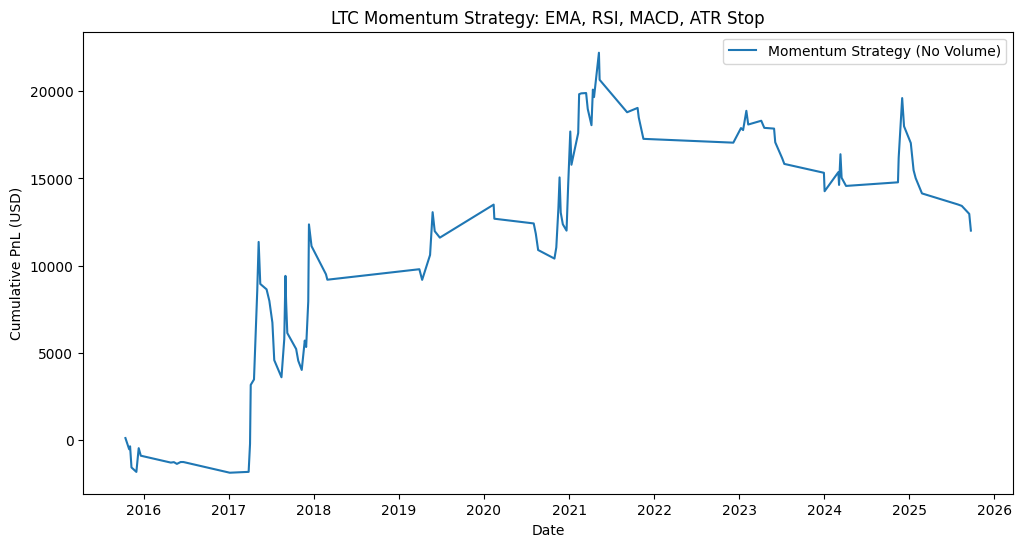


All Trades:
                   entry_date                 exit_date  year  side  \
0   2015-10-08 00:00:00+00:00 2015-10-15 00:00:00+00:00  2015  long   
1   2015-10-30 00:00:00+00:00 2015-10-31 00:00:00+00:00  2015  long   
2   2015-11-02 00:00:00+00:00 2015-11-04 00:00:00+00:00  2015  long   
3   2015-11-06 00:00:00+00:00 2015-11-10 00:00:00+00:00  2015  long   
4   2015-11-28 00:00:00+00:00 2015-12-01 00:00:00+00:00  2015  long   
..                        ...                       ...   ...   ...   
99  2025-02-16 00:00:00+00:00 2025-02-24 00:00:00+00:00  2025  long   
100 2025-07-21 00:00:00+00:00 2025-07-28 00:00:00+00:00  2025  long   
101 2025-08-07 00:00:00+00:00 2025-08-14 00:00:00+00:00  2025  long   
102 2025-09-13 00:00:00+00:00 2025-09-15 00:00:00+00:00  2025  long   
103 2025-09-17 00:00:00+00:00 2025-09-22 00:00:00+00:00  2025  long   

     entry_price  exit_price          pnl outcome  
0           3.06        3.10   130.718954     win  
1           4.06        3.80  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ltc = pd.read_csv("New_Query (2).csv", parse_dates=["day"])
ltc = ltc.sort_values("day").reset_index(drop=True)

# --- Parameters ---
ema_short = 20
ema_long = 50
ema_med = 100
atr_period = 14
rsi_period = 14
notional = 10000

# --- Indicators ---
ltc["EMA20"] = ltc["close_usd"].ewm(span=ema_short, adjust=False).mean()
ltc["EMA50"] = ltc["close_usd"].ewm(span=ema_long, adjust=False).mean()
ltc["EMA100"] = ltc["close_usd"].ewm(span=ema_med, adjust=False).mean()

delta = ltc["close_usd"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(rsi_period).mean()
avg_loss = loss.rolling(rsi_period).mean()
rs = avg_gain / avg_loss
ltc["RSI"] = 100 - (100 / (1 + rs))

ltc["prev_close_fill"] = ltc["close_usd"].shift(1)
ltc["H-L"] = ltc["high_usd"] - ltc["low_usd"]
ltc["H-PC"] = (ltc["high_usd"] - ltc["prev_close_fill"]).abs()
ltc["L-PC"] = (ltc["low_usd"] - ltc["prev_close_fill"]).abs()
ltc["TR"] = ltc[["H-L", "H-PC", "L-PC"]].max(axis=1)
ltc["ATR14"] = ltc["TR"].rolling(atr_period).mean()

# MACD
ltc["EMA12"] = ltc["close_usd"].ewm(span=12, adjust=False).mean()
ltc["EMA26"] = ltc["close_usd"].ewm(span=26, adjust=False).mean()
ltc["MACD"] = ltc["EMA12"] - ltc["EMA26"]
ltc["MACD_Signal"] = ltc["MACD"].ewm(span=9, adjust=False).mean()

trades = []
in_position = False
entry_price = 0.0
stop_loss = 0.0
take_profit = 0.0
size = 0
entry_date = None
signal_confirmed = 0

for i in range(1, len(ltc)):
    row = ltc.iloc[i]
    signal = (
        row["EMA20"] > row["EMA50"] > row["EMA100"]
        and row["RSI"] > 55
        and row["MACD"] > row["MACD_Signal"]
        and row["MACD"] > 0
    )
    if not in_position and not np.isnan(row["ATR14"]):
        if signal:
            signal_confirmed += 1
        else:
            signal_confirmed = 0
        if signal_confirmed >= 2:  # Signal must persist
            in_position = True
            entry_price = row["close_usd"]
            size = notional / entry_price
            stop_loss = entry_price - 1.5 * row["ATR14"]
            take_profit = entry_price + 2.5 * row["ATR14"]
            entry_date = row["day"]
            signal_confirmed = 0

    elif in_position:
        # Move stop loss up to trail if price rises
        if row["close_usd"] > entry_price:
            stop_loss = max(stop_loss, row["close_usd"] - 1.2 * row["ATR14"])
        exit_signal = (
            row["EMA20"] < row["EMA50"]
            or row["close_usd"] <= stop_loss
            or row["close_usd"] >= take_profit
            or row["RSI"] < 48
        )
        if exit_signal:
            exit_price = row["close_usd"]
            exit_date = row["day"]
            pnl = (exit_price - entry_price) * size
            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "year": exit_date.year,
                "side": "long",
                "entry_price": entry_price,
                "exit_price": exit_price,
                "pnl": pnl,
                "outcome": "win" if pnl > 0 else "loss"
            })
            in_position = False

trades_df = pd.DataFrame(trades)
trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()
yearly_strategy = trades_df.groupby("year")["pnl"].sum()

ltc["year"] = ltc["day"].dt.year
yearly_bh = {}
for year in sorted(ltc["year"].unique()):
    year_data = ltc[ltc["year"] == year]
    if not year_data.empty:
        start_price = year_data["close_usd"].iloc[0]
        end_price = year_data["close_usd"].iloc[-1]
        bh_pnl = (end_price - start_price) / start_price * notional
        yearly_bh[year] = bh_pnl
yearly_bh = pd.Series(yearly_bh)

comparison = pd.DataFrame({
    "Strategy PnL": yearly_strategy,
    "Buy&Hold PnL": yearly_bh
}).fillna(0)

plt.figure(figsize=(12,6))
plt.plot(trades_df["exit_date"], trades_df["cumulative_pnl"], label="Momentum Strategy (No Volume)")
plt.title("LTC Momentum Strategy: EMA, RSI, MACD, ATR Stop")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (USD)")
plt.legend()
plt.show()

print("\nAll Trades:")
print(trades_df[["entry_date","exit_date","year","side","entry_price","exit_price","pnl","outcome"]])
print("\nYearly PnL Comparison:")
print(comparison)
print("\nTotal Strategy PnL:", trades_df["pnl"].sum())
print("Total Buy&Hold PnL:", yearly_bh.sum())
